In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor

### Helper Functions

In [2]:
def loadData(file):
    data = pd.read_csv(file)
    print('Raw shape: ',data.shape)
    data['Date'] = pd.to_datetime(data.Date)
    data['DOLocationID'] = data['DOLocationID'].astype(str)
    print('Days: ',len(set(data.Date)))
    return data

In [3]:
def getTimeSeries(df):
    table = pd.pivot_table(df, values='vehicle_count', index=['Date','Hour'],
                    columns=['DOLocationID'], aggfunc=np.sum, fill_value=0)
    return table

In [4]:
def zscoreNormalizeSpatial(matrix):
    m = matrix.copy()
    for i in range(m.shape[0]):
        m[i, :] = (m[i, :] - m[i, :].mean()) / (m[i, :].std()+1e-10)
        
    return m

In [5]:
def standardize(matrix):
    m = matrix.copy()
    scaler = StandardScaler()
    scaler.fit(m)
    t = scaler.transform(m)
    return scaler, t

In [6]:
def inverse_standardize(matrix, scaler):
    t = matrix.copy()
    return scaler.inverse_transform(t)

In [7]:
def addLag(dataset, maxlag, lagColumns):
    dataset_list = [dataset]

    for l in range(1, maxlag+1):
        df = dataset.shift(l)
        df = df[lagColumns]
        df.columns = [c+'_lag_'+str(l) for c in df.columns]
        dataset_list.append(df)

    dataset = pd.concat(dataset_list, axis=1).dropna()
    return dataset

In [8]:
def get_rmse(matrix1, matrix2):
    sumSquareError = np.mean(np.power(matrix1 - matrix2,2))
    rmse = np.power(sumSquareError,0.5)
    return rmse

In [9]:
def get_weights(rawdata, zontoBorough):
    
    rawdata['Borough'] = rawdata['DOLocationID'].apply(lambda x:zontoBorough[x])
    
    borough_df = rawdata[['vehicle_count','Borough']].groupby(by='Borough').sum().reset_index()

    zone_df = rawdata[['vehicle_count','DOLocationID']].groupby(by='DOLocationID').sum().reset_index()

    zone_df['Borough'] = zone_df['DOLocationID'].apply(lambda x:zontoBorough[x])

    zone_df = pd.merge(borough_df, zone_df, on=['Borough'], how='inner')

    zone_df['zone_weight'] = zone_df.vehicle_count_y / zone_df.vehicle_count_x

    zone_df = zone_df[['Borough', 'DOLocationID', 'zone_weight']]

    return zone_df

#### Load Raw Data

In [10]:
hub = 'Lga'
tune_hyp_params = False

In [11]:
dataDir = '/home/urwa/Documents/Projects/NYU Remote/project/data/processedData/'
file = dataDir + hub + 'VehiceByHour.csv'

In [12]:
rawdata = loadData(file)

Raw shape:  (2251320, 4)
Days:  365


In [13]:
rawdata.head(2)

,DOLocationID,Date,Hour,vehicle_count
0,1,2018-01-01,0,0.0
1,2,2018-01-01,0,0.0


In [14]:
edge_data = getTimeSeries(rawdata)
edge_data = edge_data.reset_index()
edge_data.head(3)

DOLocationID,Date,Hour,1,10,100,101,102,106,107,108,...,90,91,92,93,94,95,96,97,98,99
0,2018-01-01,0,0,0,0,0,0,2,1,0,...,0,0,1,0,1,0,0,1,0,0
1,2018-01-01,1,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,2018-01-01,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Burrough Level Aggregation

In [15]:
zones = pd.read_csv('/home/urwa/Documents/Projects/NYU Remote/project/UrbanTemporalNetworks/Data/taxi_zones.csv')
zones['LocationID'] = zones['LocationID'].astype(str)
zones.head(2)

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
0,1,0.116357,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.000782,Newark Airport,1,EWR
1,2,0.433470,MULTIPOLYGON (((-73.82337597260663 40.63898704...,0.004866,Jamaica Bay,2,Queens


In [16]:
zontoBorough = dict(zip(zones.LocationID.values,zones.borough.values))

In [17]:
zone_weights = get_weights(rawdata, zontoBorough)
zone_weights.head(2)

,Borough,DOLocationID,zone_weight
0,Bronx,119,0.024243
1,Bronx,126,0.017055


In [18]:
rawdata['DOLocationID'] = rawdata['DOLocationID'].apply(lambda x:zontoBorough[x])
rawdata.head(2)

,DOLocationID,Date,Hour,vehicle_count,Borough
0,EWR,2018-01-01,0,0.0,EWR
1,Queens,2018-01-01,0,0.0,Queens


In [19]:
borough_data = getTimeSeries(rawdata)
borough_data = borough_data.reset_index()
borough_data.head(3)

DOLocationID,Date,Hour,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island
0,2018-01-01,0,8,40,0,55,36,3
1,2018-01-01,1,1,2,0,11,9,0
2,2018-01-01,2,1,0,0,0,1,0


### Merge External Data Features

In [20]:
externalDataDir = "/home/urwa/Documents/Projects/NYU Remote/project/data/HongData/"
extFile = externalDataDir + hub.upper() + ".csv"

In [21]:
extDf = pd.read_csv(extFile)
print(extDf.shape)
extDf.head(2)

(8760, 46)


,date,arrival,fhv,yellow,vehicle,ifmon,iftue,ifwed,ifthu,iffri,...,maxtemp,mintemp,avgtemp,departure,hdd,cdd,participation,newsnow,snowdepth,ifSnow
0,18/1/1 0:00,3,89,67,156,1,0,0,0,0,...,19,8,13.5,-20.5,51,0,0.0,0.0,0,0
1,18/1/1 1:00,0,17,8,25,1,0,0,0,0,...,19,8,13.5,-20.5,51,0,0.0,0.0,0,0


In [22]:
extDf['date'] = pd.to_datetime(extDf['date'], yearfirst=True)
extDf.head(2)

,date,arrival,fhv,yellow,vehicle,ifmon,iftue,ifwed,ifthu,iffri,...,maxtemp,mintemp,avgtemp,departure,hdd,cdd,participation,newsnow,snowdepth,ifSnow
0,2018-01-01 00:00:00,3,89,67,156,1,0,0,0,0,...,19,8,13.5,-20.5,51,0,0.0,0.0,0,0
1,2018-01-01 01:00:00,0,17,8,25,1,0,0,0,0,...,19,8,13.5,-20.5,51,0,0.0,0.0,0,0


In [23]:
min(extDf.date), max(extDf.date)

(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-12-31 23:00:00'))

In [24]:
extDf['Hour'] = extDf['date'].dt.hour
extDf['Dow'] = extDf['date'].dt.dayofweek
extDf['Date'] = extDf['date'].dt.date

In [25]:
extDf.columns

Index(['date', 'arrival', 'fhv', 'yellow', 'vehicle', 'ifmon', 'iftue',
       'ifwed', 'ifthu', 'iffri', 'ifsat', 'ifsun', 'if0', 'if1', 'if2', 'if3',
       'if4', 'if5', 'if6', 'if7', 'if8', 'if9', 'if10', 'if11', 'if12',
       'if13', 'if14', 'if15', 'if16', 'if17', 'if18', 'if19', 'if20', 'if21',
       'if22', 'if23', 'maxtemp', 'mintemp', 'avgtemp', 'departure', 'hdd',
       'cdd', 'participation', 'newsnow', 'snowdepth', 'ifSnow', 'Hour', 'Dow',
       'Date'],
      dtype='object')

In [26]:
selected_columns = ['Date', 'Hour', 'Dow', 'arrival','maxtemp', 'mintemp', 'avgtemp', 'departure', 'hdd',
       'cdd', 'participation', 'newsnow', 'snowdepth', 'ifSnow']

In [27]:
extDf = extDf[selected_columns]

In [28]:
print(borough_data.shape)
print(extDf.shape)

(8760, 8)
(8760, 14)


In [29]:
borough_data['Date'] = pd.to_datetime(borough_data['Date'])
extDf['Date'] = pd.to_datetime(extDf['Date'])

In [30]:
borough_data = pd.merge(borough_data,extDf, on=['Date', 'Hour'], how='inner')
print(borough_data.shape)
borough_data['Date'] = borough_data['Date'].dt.date
borough_data.head()

(8760, 20)


,Date,Hour,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island,Dow,arrival,maxtemp,mintemp,avgtemp,departure,hdd,cdd,participation,newsnow,snowdepth,ifSnow
0,2018-01-01,0,8,40,0,55,36,3,0,3,19,8,13.5,-20.5,51,0,0.0,0.0,0,0
1,2018-01-01,1,1,2,0,11,9,0,0,0,19,8,13.5,-20.5,51,0,0.0,0.0,0,0
2,2018-01-01,2,1,0,0,0,1,0,0,1,19,8,13.5,-20.5,51,0,0.0,0.0,0,0
3,2018-01-01,3,0,1,0,0,0,0,0,0,19,8,13.5,-20.5,51,0,0.0,0.0,0,0
4,2018-01-01,4,0,0,1,3,9,0,0,0,19,8,13.5,-20.5,51,0,0.0,0.0,0,0


### Train Test split

In [31]:
sep = int(0.75*len(borough_data))
sep

6570

In [32]:
trainData = borough_data[:sep]
testData = borough_data[sep:]

In [33]:
trainData.shape

(6570, 20)

In [34]:
testData.shape

(2190, 20)

### Lag Variables

In [35]:
trainData.columns

Index(['Date', 'Hour', 'Bronx', 'Brooklyn', 'EWR', 'Manhattan', 'Queens',
       'Staten Island', 'Dow', 'arrival', 'maxtemp', 'mintemp', 'avgtemp',
       'departure', 'hdd', 'cdd', 'participation', 'newsnow', 'snowdepth',
       'ifSnow'],
      dtype='object')

In [36]:
lagColumns = ['Bronx', 'Brooklyn', 'EWR', 'Manhattan', 'Queens',
       'Staten Island', 'arrival']

DateColumns = ['Date']

targetColumns = ['Bronx', 'Brooklyn', 'EWR', 'Manhattan', 'Queens',
       'Staten Island']

In [37]:
maxlag = 12

dataset_train = addLag(trainData, maxlag, lagColumns)

dataset_train.shape

(6558, 104)

In [38]:
dataset_test = addLag(testData, maxlag, lagColumns)
dataset_test.shape

(2178, 104)

### Modelling

In [39]:
X_train = dataset_train.drop(targetColumns+DateColumns , axis = 1)
X_test = dataset_test.drop(targetColumns+DateColumns , axis = 1)
y_train = dataset_train[targetColumns]
y_test = dataset_test[targetColumns]

In [40]:
X_train.shape, X_test.shape

((6558, 97), (2178, 97))

In [41]:
y_train.shape, y_test.shape

((6558, 6), (2178, 6))

### Hyperparameter Tuning

In [42]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 300, num = 3)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,3,4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,3]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [150, 225, 300], 'max_features': ['sqrt'], 'max_depth': [50, 65, 80, 95, 110, None], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [2, 3], 'bootstrap': [True, False]}


In [43]:
if tune_hyp_params:
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, \
                                   cv = 5, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    rf_random.best_params_

### Training the Best Model

In [44]:
rf2 = RandomForestRegressor(random_state = 2019, n_estimators=150, 
                           min_samples_split=3,
                           min_samples_leaf= 2, 
                           max_features= 'sqrt',
                           max_depth= None, 
                           bootstrap= False)

In [45]:
rf2.fit(X_train,y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
           oob_score=False, random_state=2019, verbose=0, warm_start=False)

In [46]:
rf2.score(X_train,y_train)

0.9977933260655573

In [47]:
rf2.score(X_test,y_test)

0.9138260033392079

### Predict

In [48]:
borough_prediction = rf2.predict(X_test)
borough_prediction.shape

(2178, 6)

### Evaluate

In [49]:
get_rmse(y_test, borough_prediction)

Bronx             5.741673
Brooklyn         30.927703
EWR               1.019362
Manhattan        99.756255
Queens           20.623709
Staten Island     0.744232
dtype: float64

In [50]:
r2_score(y_test, borough_prediction, multioutput='variance_weighted')

0.9138260033392079

In [51]:
y_test.mean()

Bronx             15.161157
Brooklyn          98.669881
EWR                0.740129
Manhattan        455.013315
Queens            92.496786
Staten Island      0.542700
dtype: float64

### Edge Level Evaluation

In [52]:
borough_prediction.shape

(2178, 6)

In [53]:
edge_prediction_df = pd.DataFrame(borough_prediction)
edge_prediction_df.columns = y_test.columns
edge_prediction_df.head(2)

,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island
0,1.747778,7.572222,0.387778,36.495556,12.885556,0.048889
1,5.723333,26.512222,0.401111,318.632222,39.237778,0.226667


In [54]:
boroughs = list(edge_prediction_df.columns)
for bor in boroughs:
    print(bor)
    
    weight_df = zone_weights[zone_weights.Borough == bor]
    
    print(len(weight_df.DOLocationID))
    
    for b_zone,z_weight in zip(weight_df.DOLocationID.values,weight_df.zone_weight.values):        
        edge_prediction_df[b_zone] = edge_prediction_df[bor] * z_weight

Bronx
43
Brooklyn
61
EWR
1
Manhattan
66
Queens
67
Staten Island
19


In [55]:
select_cols = [c for c in edge_prediction_df.columns if c not in boroughs]
edge_prediction_df = edge_prediction_df[select_cols]
edge_prediction_df.shape

(2178, 257)

In [56]:
edge_testData = edge_data[sep+maxlag:]
select_cols = [c for c in edge_testData.columns if c not in ['Date','Hour']]
edge_testData = edge_testData[select_cols]
edge_testData.shape

(2178, 257)

In [57]:
edge_prediction_df = edge_prediction_df[edge_testData.columns]
edge_prediction_df.head(2)

,1,10,100,101,102,106,107,108,109,11,...,90,91,92,93,94,95,96,97,98,99
0,0.387778,0.120587,0.927925,0.061411,0.058124,0.074251,0.772053,0.007826,0.002103,0.009149,...,0.504359,0.037381,0.509058,0.099809,0.014504,0.571669,0.007381,0.247440,0.116592,0.000252
1,0.401111,0.367198,8.101446,0.187003,0.176992,0.259971,6.740570,0.027400,0.009750,0.032033,...,4.403412,0.130879,1.550130,0.303929,0.047495,1.740787,0.022474,0.866349,0.355035,0.001166


In [58]:
edge_testData.head(2)

DOLocationID,1,10,100,101,102,106,107,108,109,11,...,90,91,92,93,94,95,96,97,98,99
6582,0,0,0,0,0,0,1,0,0,0,...,1,0,2,0,0,3,0,1,2,0
6583,0,0,24,1,0,0,7,0,0,0,...,5,0,2,1,0,0,0,0,0,0


In [59]:
get_rmse(edge_testData.values, edge_prediction_df.values)

3.0444771403719355

In [60]:
r2_score(edge_testData.values, edge_prediction_df.values, multioutput='variance_weighted')

0.6023665491405238

In [61]:
np.mean(edge_testData.values)

2.578303373315754

In [62]:
np.std(edge_testData.values)

6.550096785025455

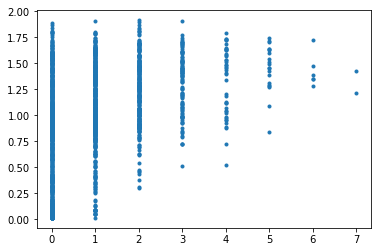

In [63]:
plt.plot(edge_testData['10'], edge_prediction_df['10'], '.')

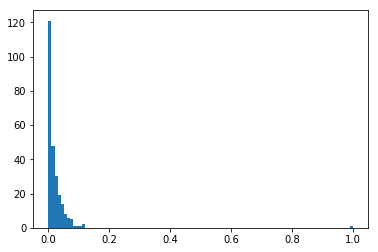

In [64]:
_=plt.hist(zone_weights.zone_weight,bins=100)